In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
from iminuit import Minuit
from iminuit.cost import LeastSquares
import pickle
from scipy.interpolate import UnivariateSpline
from scipy.signal import find_peaks

In [11]:
directory="/Users/ryan/arratia_lab/PTRG_Analysis/"
os.chdir(directory)

# Dataframe Creation

In [12]:
#PTRIG
run=2 #Each iteration manually change run # and Caen unit number if needed
with open(f'Run{run}_list.txt') as f:
    lines = f.read().split('\n')
tags = None
IDs=[]
layers=[]
channels =[]
timeStamps = []
allChannelsHG = []
din={}
for line in lines:
    if line[:2]=="//" or len(line)==0:
        continue
    #first line after comments
    if tags is None:
        tags = line.split()
        tags=tags[-3:]
        continue;
#    print(line)
    split = line.split()
    layer, channel, LG, HG = split[0:4]
#    ID=f"{layer}-{channel}"
    ID=int(layer)*64+int(channel)
#    print(ID)
    if ID not in IDs:
        din[f"{ID}_LG"] = []
        din[f"{ID}_HG"] = []
        IDs.append(ID)
    din[f"{ID}_LG"].append(float(LG))
    din[f"{ID}_HG"].append(float(HG))
    allChannelsHG.append(float(HG))
    if len(split) > 4:
        layer, channel, LG, HG, time = split[0:5]
        timeStamps.append(float(time))


In [13]:
#Pulling HG/LG bias values from info file

with open(f'Run{run}_Info.txt') as f:
    lines = f.read().split('\n')
for line in lines:  
    if 'HG_Gain' in line:
        HG_gain = line.split()[1]  
    if 'LG_Gain' in line:
        LG_gain=line.split()[1]
print(HG_gain)
print(LG_gain)

58
1


Text(0.5, 1.0, 'Ch 0 HG Cosmic')

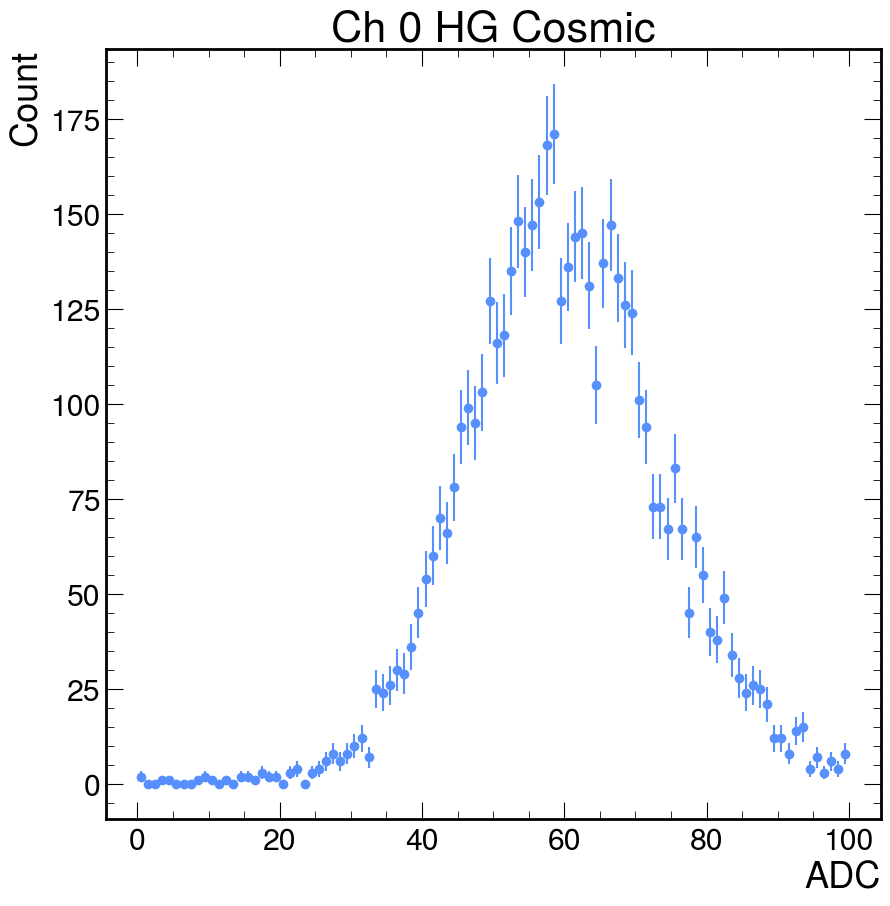

In [14]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'
plt.rcParams['savefig.bbox'] = 'tight'
hep.style.use(hep.style.CMS)

channelHG = np.array(din[f"0_HG"])
counts, bin_edges = np.histogram(channelHG, bins=100, range = [0,100], density=False)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_centers = np.array(bin_centers)
counts = np.array(counts)
errors = np.sqrt(counts)
plt.errorbar(bin_centers, counts, yerr=errors, fmt='o')
#plt.yscale('log')
plt.ylabel("Count")
plt.xlabel("ADC")
plt.title("Ch 0 HG Cosmic")

In [15]:
os.chdir('run_data')
if not os.path.exists(f"Run{run}_graphs"):
    os.mkdir(f"Run{run}_graphs")
    print(f"Folder '{f"Run{run}_graphs"}' created.")
else:
    print(f"Folder '{f"Run{run}_graphs"}' already exists.")

Folder 'Run2_graphs' created.


## HG Plots

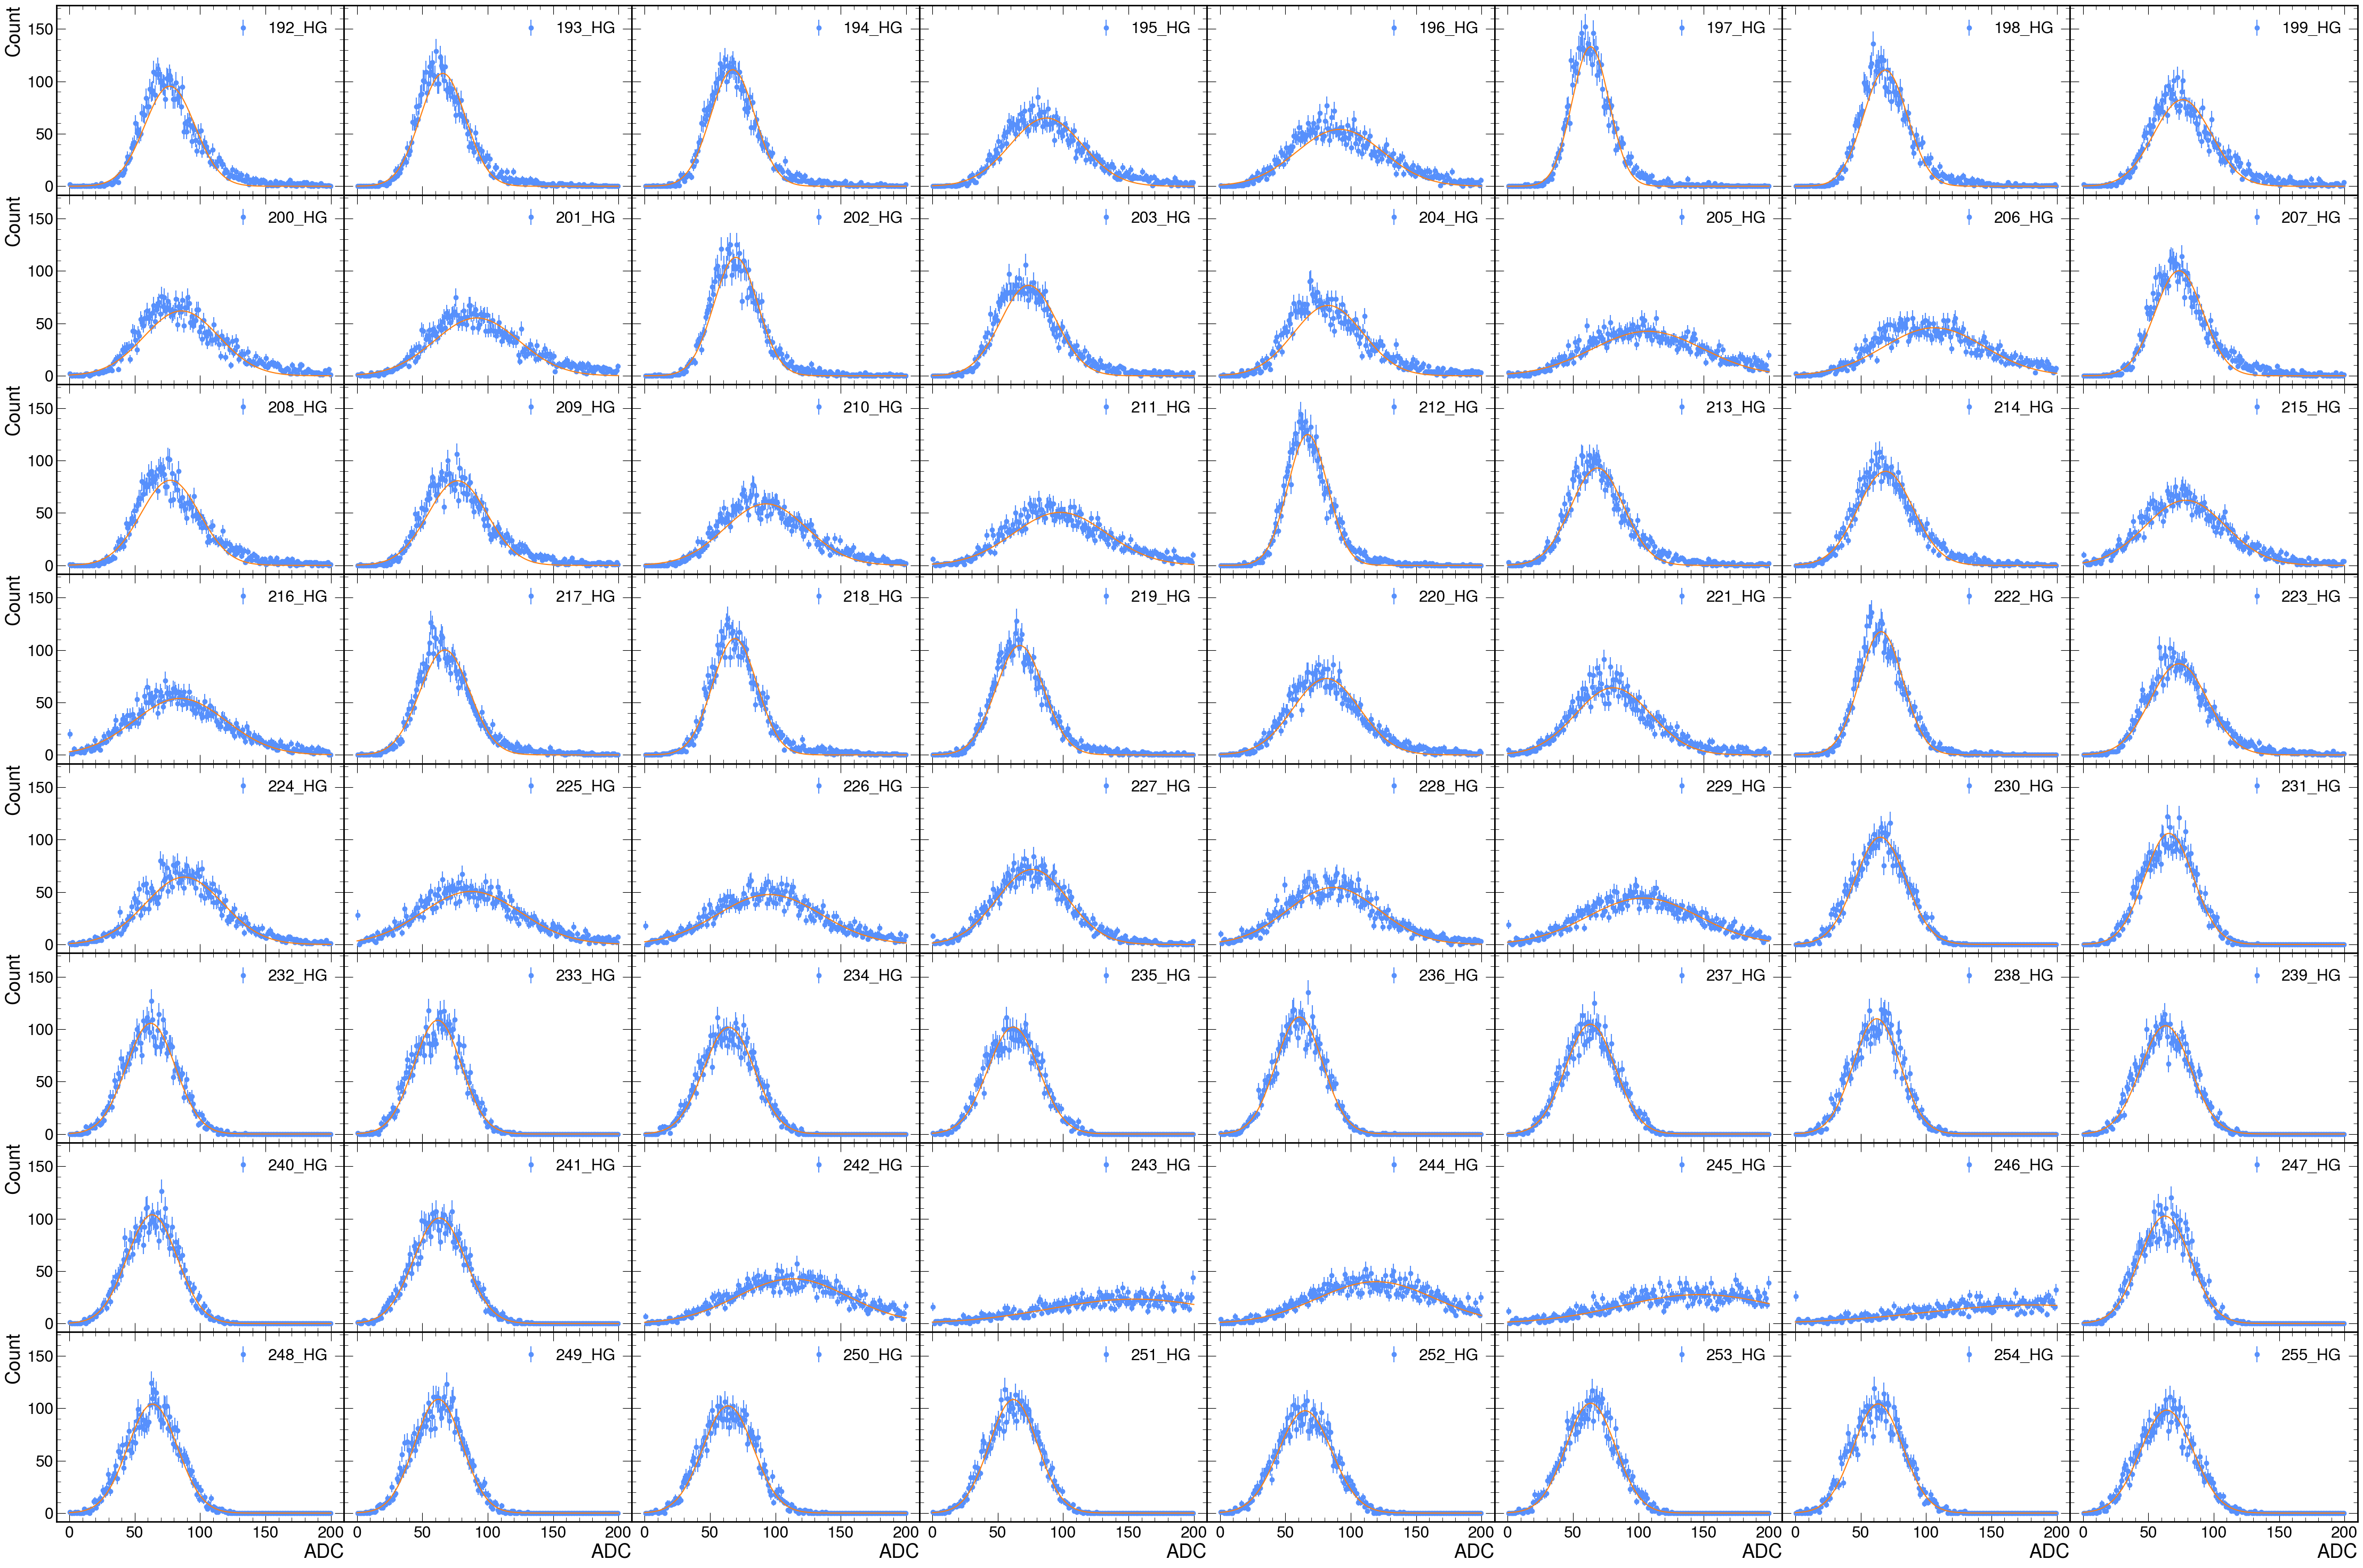

In [16]:
num_channels = 64
HGPeds = []
HGPedStd = []
HGPedsErr = []
HGPedStdErr = []
graphsdict = {}

CAEN_num=6 #number of caen units

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'
plt.rcParams['savefig.bbox'] = 'tight'
hep.style.use(hep.style.CMS)

def gauss(x, A, mu, sigma):
    return A * np.exp(-(x - mu) ** 2 / (2. * sigma ** 2))

# Determine the grid size
num_cols = 8
num_rows = 8

# Choose the specific 'n' value for which you want to display plots
display_n =3  # Set this to your desired 'n' value

# Initialize the figure and axes for plotting
fig, axes = plt.subplots(num_rows, num_cols, figsize=(30, 30), sharey=True, sharex=True)
axes = axes.flatten()

for n in range(CAEN_num):  # Number of CAEN units
    for i in range(num_channels):
        channel_key = f"{i+(64*n)}_HG"
        data = np.array(din[channel_key])
        counts, bin_edges = np.histogram(data, bins=200, range=[0, 200])
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        yerrors = np.sqrt(counts)
        mask = (counts > 0)
        initial_params = [max(counts[mask]), np.mean(data), np.std(data)]
        m=Minuit(LeastSquares(bin_centers[mask], counts[mask], yerrors[mask], gauss), A=initial_params[0], mu=initial_params[1], sigma=initial_params[2])
        m.limits["sigma"] = (0, None)
        m.migrad()
        fitted_params = m.values
        errors = m.errors
        #print(errors)
        mu_fit = fitted_params['mu']
        sigma_fit = fitted_params['sigma']
        HGPeds.append(mu_fit)
        HGPedStd.append(sigma_fit)
        HGPedsErr.append(errors['mu'])
        HGPedStdErr.append(errors['sigma'])

        # Plot only for the chosen 'n' value
        if n == display_n:
            x = np.linspace(0, 200, 1500)
            y_fit = gauss(x, fitted_params['A'], mu_fit, sigma_fit)
            axes[i].errorbar(bin_centers, counts, yerr=yerrors, fmt='o', label=channel_key)
            axes[i].plot(x, y_fit, color='tab:orange', zorder=101)
            axes[i].legend()
            if i % num_cols == 0:
                axes[i].set_ylabel('Count')
            if i >= (num_rows - 1) * num_cols:
                axes[i].set_xlabel('ADC')

# Adjust layout and display the plot
if display_n in range(6):
    plt.tight_layout(pad=0.0)
    plt.tight_layout(rect=[0, 0, 1.5, 1])
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.savefig(f"Run{run}_graphs/Run{run}_CAEN{display_n}_subplots.png")
    plt.show()
else:
    print(f"No plots to display for n = {display_n}")


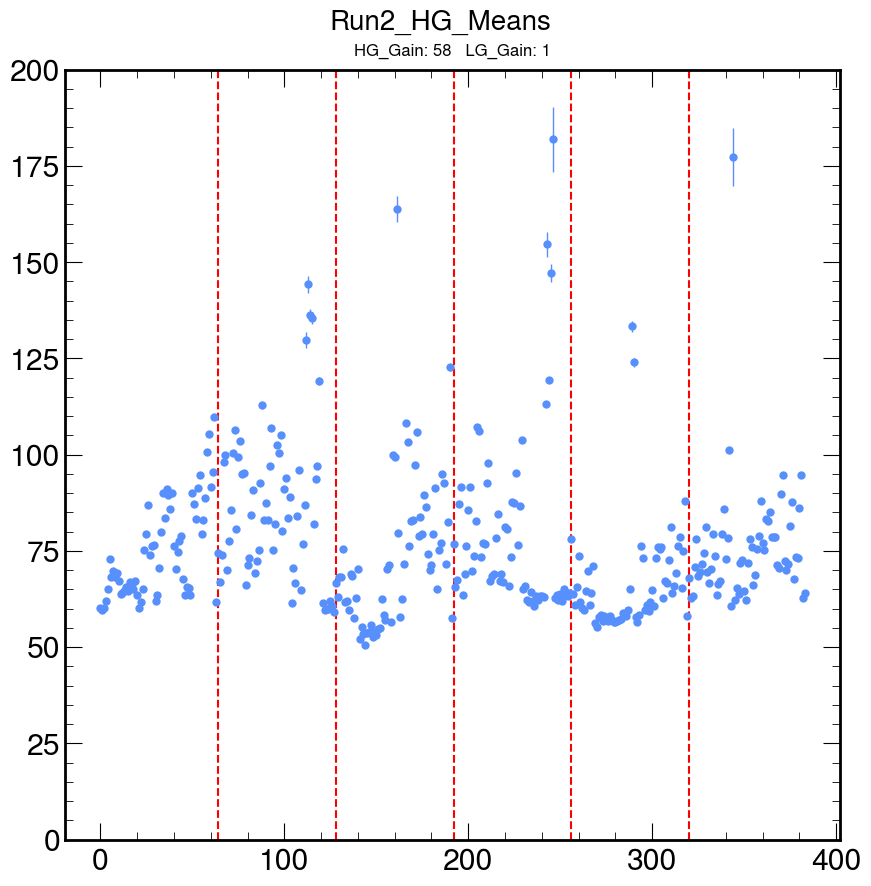

In [23]:
fig, ax = plt.subplots()
fig.suptitle(f"Run{run}_HG_Means\n ", fontsize=20,y=0.94)
ax.set_title(f"HG_Gain: {HG_gain}   LG_Gain: {LG_gain}", fontsize=12, pad=10) 

plt.errorbar(range(0,CAEN_num*64),HGPeds, fmt='o',yerr=HGPedsErr, capsize=0, elinewidth=1, markeredgewidth=0)

plt.ylim(0,200)

for i in range(1,6): #5 is number of caen units
    plt.axvline(x=i*64, color='red', linestyle='--')

plt.savefig(f"Run{run}_graphs/Run{run}_HG_Means.png")

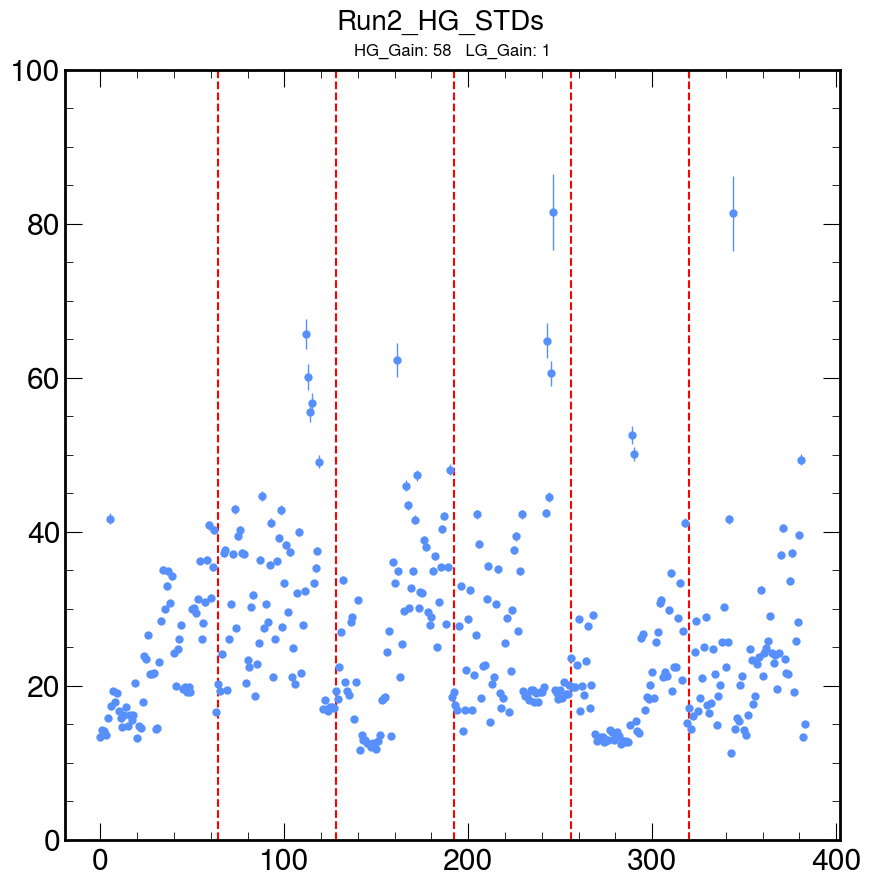

In [21]:
fig, ax = plt.subplots()
fig.suptitle(f"Run{run}_HG_STDs\n ", fontsize=20,y=0.94)
ax.set_title(f"HG_Gain: {HG_gain}   LG_Gain: {LG_gain}", fontsize=12, pad=10) 
plt.errorbar(range(0,CAEN_num*64),HGPedStd, fmt='o',yerr=HGPedStdErr, capsize=0, elinewidth=1, markeredgewidth=0)
plt.ylim(0,100)

for i in range(1,6): #5 is number of caen units
    plt.axvline(x=i*64, color='red', linestyle='--')

plt.savefig(f"Run{run}_graphs/Run{run}_HG_STDs.png")